In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
import time

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.8.0
sys.version_info(major=3, minor=7, micro=13, releaselevel='final', serial=0)
matplotlib 3.2.2
numpy 1.21.6
pandas 1.3.5
sklearn 1.0.2
tensorflow 2.8.0
keras.api._v2.keras 2.8.0


In [3]:
!nvidia-smi

Mon May 23 03:28:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import unicodedata
import re
from sklearn.model_selection import train_test_split

In [5]:
# 这里正则表达式中的^：一直吃直到......（可以理解为“取反”）
b = "I am a[]=+ man!. ? &***()"
b = re.sub(r"[^a-zA-Z?.!,¿]+", " ", b)
print(b)
c = '12345 im asn'
c = re.sub(r"[^a-z]+", "", c)
print(c)

I am a man!. ? 
imasn


In [6]:
# 因为西班牙语有一些是特殊字符，所以需要unicode转ascii
# 这样值变小了，因为unicode太大
def unicode_to_ascii(s):
    # NFD是转换方法，把每一个字节拆开，Mn是重音，所以去除
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

# 简单测试
# 加u代表对字符串进行unicode编码
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"

print(unicode_to_ascii(en_sentence))
print(unicode_to_ascii(sp_sentence))


def preprocess_sentence(w):
    # 变为小写，去掉多余的空格
    w = unicode_to_ascii(w.lower().strip())

    # 在单词与跟在其后的标点符号之间插入一个空格
    # eg: "he is a boy." => "he is a boy . "
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    # 因为可能有多余空格，替换为一个空格，所以处理一下
    w = re.sub(r'[" "]+', " ", w)

    # 除了 (a-z, A-Z, ".", "?", "!", ",")，将所有字符替换为空格（上一个cell中有演示）
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))  # ¿是占用两个字节的

May I borrow this book?
¿Puedo tomar prestado este libro?
<start> may i borrow this book ? <end>
<start> ¿ puedo tomar prestado este libro ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [7]:
data_path = './spa.txt'

# 1. Remove the accents  移除口音
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]--> 前面西班牙，后面英文
def create_dataset(path, num_examples):
    lines = open(path, encoding='UTF-8').read().strip().split('\n')
    # word_pairs是二维列表
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
    
    return zip(*word_pairs)

en, sp = create_dataset(data_path, None)
print(type(en))
print(type(sp))
print(len(en))
print(en[-1])
print(sp[-1])


<class 'tuple'>
<class 'tuple'>
118964
<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [8]:
# zip演示
a=[ [1, 2],[3,4],[5,6] ]
c,d=zip(*a)  # *：解包
print(c,d)


(1, 3, 5) (2, 4, 6)


In [9]:
def max_length(tensor):
    return max(len(t) for t in tensor)

def tokenize(lang):
    # Tokenizer帮我们把词语式的转换为id式的，filters是黑名单
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)
    # 把一个一个的单词变为id
    tensor = lang_tokenizer.texts_to_sequences(lang)
    # 做padding，向最大的补齐
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor, lang_tokenizer

def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs，目前是西班牙语翻译为英语
    targ_lang, inp_lang = create_dataset(path, num_examples)  # 如果要翻译互换，只需交换这里

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

# Try experimenting with the size of that dataset
num_examples = 30000
# inp_lang  targ_lang 是tokenizer
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(data_path, num_examples)
print('-'*50)
print(input_tensor.shape, target_tensor.shape, inp_lang, targ_lang)
print('-'*50)
print(input_tensor[0])
print(target_tensor[0])
print(input_tensor[29999])
print(target_tensor[29999])
# Calculate max_length of the target tensors，可以看下最长的样本
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)
print(max_length_targ, max_length_inp)

--------------------------------------------------
(30000, 16) (30000, 11) <keras_preprocessing.text.Tokenizer object at 0x7f63ee8ec0d0> <keras_preprocessing.text.Tokenizer object at 0x7f63ececba50>
--------------------------------------------------
[  1 135   3   2   0   0   0   0   0   0   0   0   0   0   0   0]
[ 1 36  3  2  0  0  0  0  0  0  0]
[   1   23 2175   10   39   98   87  314    3    2    0    0    0    0
    0    0]
[ 1 16 38 72  6 55  3  2  0  0  0]
11 16


In [10]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(24000, 24000, 6000, 6000)

In [11]:
# 按单词进行切分的
def convert(lang, tensor):
    for t in tensor:
        # 不等于0，就打印转换
        if t != 0:
            print ("%d ----> %s" % (t, lang.index_word[t]))
            
print("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print()
print("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])
# 可以发现tokenizer正常工作

Input Language; index to word mapping
1 ----> <start>
62 ----> estan
3124 ----> peleando
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
28 ----> they
23 ----> re
863 ----> fighting
3 ----> .
2 ----> <end>


In [12]:
# 分batch
BUFFER_SIZE = len(input_tensor_train)  # 就是3万
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
# 下面两个都是超参数
embedding_dim = 256
units = 1024
# 输入的,加1考虑到padding的0
vocab_inp_size = len(inp_lang.word_index)+1
print(vocab_inp_size)
# 输出,加1考虑到padding的0
vocab_tar_size = len(targ_lang.word_index)+1
print(vocab_tar_size)
# 训练集
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)  # 最后一个batch丢弃
print(dataset)

9414
4935
<BatchDataset element_spec=(TensorSpec(shape=(64, 16), dtype=tf.int32, name=None), TensorSpec(shape=(64, 11), dtype=tf.int32, name=None))>


In [13]:
# 测试，看一下迭代
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

In [14]:
# 手法和之前的类似
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, encoding_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        # 编码单元
        self.encoding_units = encoding_units
        # 创建Embedding层
        self.embedding = keras.layers.Embedding(vocab_size, embedding_dim)
        # 定义GRU层，gru是lstm变种，gru把遗忘门和输入门变为一个，因为遗忘门+输入门=1
        # return_state返回最后一个细胞的中间状态
        self.gru = keras.layers.GRU(self.encoding_units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output,state= self.gru(x, initial_state = hidden)
        return output,state

    def initialize_hidden_state(self):  # 初始化全零的隐含状态
        return tf.zeros((self.batch_size, self.encoding_units))
    
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
# 获得初始化的hidden
sample_hidden = encoder.initialize_hidden_state()
# 获得输出和隐含状态
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
# 输出的16是长度，1024是状态的size,是因为return_sequences为True，每一个输出都需要
print('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [15]:
# 理解模型中去做的运算
encoder.variables

[<tf.Variable 'encoder/embedding/embeddings:0' shape=(9414, 256) dtype=float32, numpy=
 array([[ 0.00508187,  0.00677835, -0.00812074, ...,  0.0224557 ,
          0.03751332, -0.0232367 ],
        [-0.01384448,  0.02161532,  0.02728904, ..., -0.03109216,
         -0.03132951, -0.03317243],
        [ 0.03537544, -0.01183152,  0.0463004 , ...,  0.03646449,
          0.02015119,  0.04910404],
        ...,
        [ 0.00805224, -0.03630978,  0.03525568, ...,  0.03063103,
          0.04689275, -0.02259804],
        [ 0.02862669,  0.04981694,  0.03529224, ..., -0.02729468,
          0.02312548, -0.0399763 ],
        [ 0.04396899, -0.03623163, -0.03728576, ..., -0.03768947,
          0.0412076 , -0.02624229]], dtype=float32)>,
 <tf.Variable 'encoder/gru/gru_cell/kernel:0' shape=(256, 3072) dtype=float32, numpy=
 array([[-0.01588795,  0.02624664, -0.01251672, ...,  0.04093488,
         -0.04146188,  0.00690464],
        [-0.02303928,  0.03387072, -0.03228163, ..., -0.0070832 ,
         -0.0389

# 核心部分

In [16]:
# 实现Attention机制
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        # 做全连接
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
    
    # query传的是decoder_hidden,values是EO
    def call(self, query, values):
        # deocoder_hidden.shape: (batch_size,units)
        # encoder outputs.shape: (batch size, length,units)
        # 做维度扩展，扩展前后对比是下面两行
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(query, 1)
        
        #接下来要实现Attention,Bahdanau方式的
        # before V:(batch_size, length, units )
        # after V: (batch_size, length, 1)
        # score shape == (batch_size, max_length, 1)  （64,16,1）
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # 先算加权，values就是encoder_outputs，对应位置相乘，广播出去
        # context_vector.shape: ( batch_size, length units )
        context_vector = attention_weights * values
        print(context_vector.shape)
        # 在length的维度去求和
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights
    
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

(64, 16, 1024)
Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


In [17]:
attention_layer.variables

[<tf.Variable 'bahdanau_attention/dense/kernel:0' shape=(1024, 10) dtype=float32, numpy=
 array([[ 0.06464614, -0.00774927,  0.00676966, ...,  0.03257685,
         -0.07436984,  0.0649657 ],
        [-0.06563891, -0.06577568,  0.05749071, ...,  0.0029221 ,
          0.03592245,  0.00611632],
        [ 0.00048519, -0.05783436, -0.03657306, ..., -0.07314355,
         -0.00906719,  0.05881111],
        ...,
        [-0.00706928, -0.03874933,  0.02018823, ..., -0.02200363,
          0.07418783, -0.06143684],
        [ 0.04965284,  0.03402801,  0.022896  , ..., -0.05754478,
          0.0737655 , -0.00838722],
        [-0.05296246, -0.05527399, -0.02907558, ...,  0.035278  ,
          0.03000916, -0.06230796]], dtype=float32)>,
 <tf.Variable 'bahdanau_attention/dense/bias:0' shape=(10,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>,
 <tf.Variable 'bahdanau_attention/dense_1/kernel:0' shape=(1024, 10) dtype=float32, numpy=
 array([[-0.0492903 ,  0.020408

In [18]:
# 实现decoder
class Decoder(tf.keras.Model):
    # init传参和encoder很像
    def __init__(self, vocab_size, embedding_dim, decoding_units, batch_size):
        # 这里必须调用父类
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.decoding_units = decoding_units
        # Embedding 层
        self.embedding = keras.layers.Embedding(vocab_size, embedding_dim)
        # GRU的decoder
        self.gru = keras.layers.GRU(self.decoding_units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
        self.fc = keras.layers.Dense(vocab_size)

        # used for attention，每一步都会被调用
        self.attention = BahdanauAttention(self.decoding_units)

    # 照着原来的原理图理解
    def call(self, x, hidden, encoding_output):
        # context vector. shape: ( batch size, units）
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, encoding_output)

        # before embedding: x. shape: (batch_size, 1 )
        # after embedding : x. shape: (batch size, 1, embedding units)
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        print(context_vector.shape,x.shape)
        # 把x和context_vector拼起来，context_vector为什么要扩展维度？
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        print(x.shape)
        # passing the concatenated vector to the GRU
        # output. shape:[batch_size,1,decoding_units ]
        #state. shape:[batch_size, decoding_units ]
        output, state = self.gru(x)
        print(output.shape)
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        print('output变换后')
        print(output.shape)
        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
sample_decoder_output,decoder_hidden,decoder_aw = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)
print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))
print("decoder_hidden.shape: ", decoder_hidden.shape )
print("decoder_attention_weights.shape:", decoder_aw.shape )


(64, 16, 1024)
(64, 1024) (64, 1, 256)
(64, 1, 1280)
(64, 1, 1024)
output变换后
(64, 1024)
Decoder output shape: (batch_size, vocab size) (64, 4935)
decoder_hidden.shape:  (64, 1024)
decoder_attention_weights.shape: (64, 16, 1)


In [19]:
# 优化器选用adam
optimizer = keras.optimizers.Adam()
# 分类问题我们往往用SparseCategoricalCrossentropy，因为我们的fc是纯的输出，没有加softmax，
# 因此这里的from_logits为True，否则改为false，reduction是损失函数如何做聚合
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

# 为了把padding部分的损失去除，这样计算损失更加准确
def loss_function(real, pred):
    # 是零的时候返回结果是True，因此要取反操作
    # tf.math.equal(real, 0)是padding的部分都是1，不是padding的部分都是零，因此我们要取反
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    
    loss_ = loss_object(real, pred)  # 这里是得到的损失
    # 将张量转换为新类型,变为float类型
    mask = tf.cast(mask, dtype=loss_.dtype)
    # padding部分的mask是零
    loss_ *= mask
    # 计算累计的损失平均
    return tf.reduce_mean(loss_)

checkpoint_dir = './8-1_checkpoints'
if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [20]:
tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

<tf.Tensor: shape=(64, 1), dtype=int32, numpy=
array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=int32)>

In [21]:
@tf.function
def train_step(inp, targ, encoding_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        # 把输入给encoder，得到encoding_output, encoding_hidden
        encoding_output, encoding_hidden = encoder(inp, encoding_hidden)

        decoding_hidden = encoding_hidden  # 最初是把encoding_hidden给decoding
        # 第一次给进去的decoding_input全部是1，是64个1
        decoding_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
        
        # eg: <start> I am here <end>
        # 1.<start>->I
        # 2.I->am
        # 3.am->here
        # 4. here ->< end>
        # 对于here，我们相当于要把I am  的信息都要给过去
        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            # 根据我们前面的原理解析，我们这里需要给3项信息
            predictions, decoding_hidden, _ = decoder(decoding_input, decoding_hidden, encoding_output)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing,这里是取第t列，再扩维
            decoding_input = tf.expand_dims(targ[:, t], 1)
            
    # 这里是每个batch上平均的损失函数
    batch_loss = (loss / int(targ.shape[1]))
    print(type(encoder.trainable_variables))
    print(type(decoder.trainable_variables))
    variables = encoder.trainable_variables + decoder.trainable_variables
    # 求梯度
    gradients = tape.gradient(loss, variables)
    # 有了梯度以后，可以用optimizer去做apply
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [22]:
m=np.arange(6).reshape(3,2)
t=1
m[:,1]

array([1, 3, 5])

In [23]:
steps_per_epoch

375

In [24]:
EPOCHS = 10
# 这里运行时间比较久
for epoch in range(EPOCHS):
    start = time.time()

    encoding_hidden = encoder.initialize_hidden_state()  # 第一次，全零的隐含状态
    total_loss = 0
    # 每次去取dataset.take(steps_per_epoch)这么多数据
    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, encoding_hidden)
        total_loss += batch_loss
        # 这里增加打印
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs，保存模型
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

(64, 16, 1024)
(64, 1024) (64, 1, 256)
(64, 1, 1280)
(64, 1, 1024)
output变换后
(64, 1024)
(64, 16, 1024)
(64, 1024) (64, 1, 256)
(64, 1, 1280)
(64, 1, 1024)
output变换后
(64, 1024)
(64, 16, 1024)
(64, 1024) (64, 1, 256)
(64, 1, 1280)
(64, 1, 1024)
output变换后
(64, 1024)
(64, 16, 1024)
(64, 1024) (64, 1, 256)
(64, 1, 1280)
(64, 1, 1024)
output变换后
(64, 1024)
(64, 16, 1024)
(64, 1024) (64, 1, 256)
(64, 1, 1280)
(64, 1, 1024)
output变换后
(64, 1024)
(64, 16, 1024)
(64, 1024) (64, 1, 256)
(64, 1, 1280)
(64, 1, 1024)
output变换后
(64, 1024)
(64, 16, 1024)
(64, 1024) (64, 1, 256)
(64, 1, 1280)
(64, 1, 1024)
output变换后
(64, 1024)
(64, 16, 1024)
(64, 1024) (64, 1, 256)
(64, 1, 1280)
(64, 1, 1024)
output变换后
(64, 1024)
(64, 16, 1024)
(64, 1024) (64, 1, 256)
(64, 1, 1280)
(64, 1, 1024)
output变换后
(64, 1024)
(64, 16, 1024)
(64, 1024) (64, 1, 256)
(64, 1, 1280)
(64, 1, 1024)
output变换后
(64, 1024)
<class 'list'>
<class 'list'>
(64, 16, 1024)
(64, 1024) (64, 1, 256)
(64, 1, 1280)
(64, 1, 1024)
output变换后
(64, 1024)
(6

# 预测过程（翻译）

In [25]:
# 接收字符串，并进行翻译
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    # 对输入的语言做和训练时同样的预处理（eg: 标点符号前后加空格）后，下一步再进行word转id
    sentence = preprocess_sentence(sentence)
    # text到id的转换
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    # 加padding
    inputs = keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)  # 变为张量
    # 结果先初始化一个空串
    result = ''

    hidden = [tf.zeros((1, units))]
    encoding_out, encoding_hidden = encoder(inputs, hidden)
    # 按模型把encoding_hidden给decoding_hidden
    decoding_hidden = encoding_hidden
    # 第一次的decoding_input是全为1的（1,1)的矩阵
    decoding_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)
    # eg:<start>->A
    # A->B->C->D
    # decoding_input. shape:(1， 1)
    for t in range(max_length_targ):
        predictions, decoding_hidden, attention_weights = decoder(
            decoding_input, decoding_hidden, encoding_out)
        
        # attention weights. shape: (batch size, input length, 1) (1， 16， 1 )，需要变为长度为16的向量
        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()  # 为了画图
        # predictions.shape: (batch_ size, vocab_ size) (1, 4935)
        # 获取概率最大的值作为下一步的输入
        predicted_id = tf.argmax(predictions[0]).numpy()
        # 通过id知道单词
        result += targ_lang.index_word[predicted_id] + ' '
        
        # 终止循环
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        decoding_input = tf.expand_dims([predicted_id], 0)
    # 到此decoding_input，decoding_hidden我们都做了更新
    
    return result, sentence, attention_plot

# function for plotting the attention weights，把注意力关系完成可视化
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}
    # 把标注写上，我们需要把第零个位置空出来，看图即可看出
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

# 通过这个函数，把上面两个函数串起来
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    # 因为输出不一定有输入的长度长，也就是result长度小于输入的长度
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))
    
# 加载模型参数
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

(1, 16, 1024)
(1, 1024) (1, 1, 256)
(1, 1, 1280)
(1, 1, 1024)
output变换后
(1, 1024)
(1, 16, 1024)
(1, 1024) (1, 1, 256)
(1, 1, 1280)
(1, 1, 1024)
output变换后
(1, 1024)
(1, 16, 1024)
(1, 1024) (1, 1, 256)
(1, 1, 1280)
(1, 1, 1024)
output变换后
(1, 1024)
(1, 16, 1024)
(1, 1024) (1, 1, 256)
(1, 1, 1280)
(1, 1, 1024)
output变换后
(1, 1024)
(1, 16, 1024)
(1, 1024) (1, 1, 256)
(1, 1, 1280)
(1, 1, 1024)
output变换后
(1, 1024)
(1, 16, 1024)
(1, 1024) (1, 1, 256)
(1, 1, 1280)
(1, 1, 1024)
output变换后
(1, 1024)
(1, 16, 1024)
(1, 1024) (1, 1, 256)
(1, 1, 1280)
(1, 1, 1024)
output变换后
(1, 1024)
Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold here . <end> 


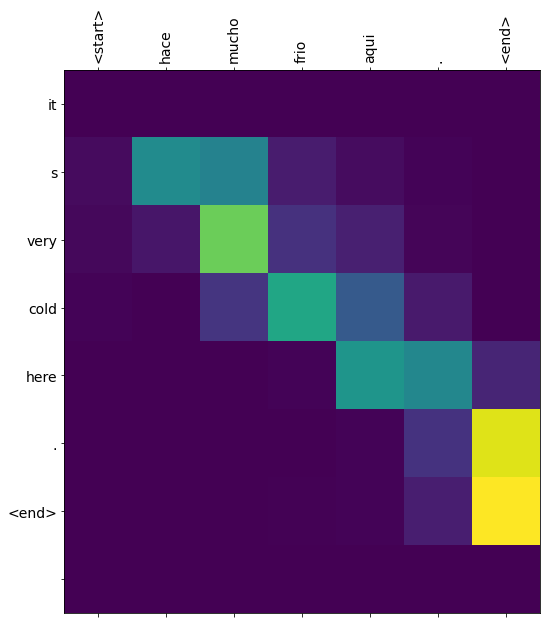

In [26]:
# it is terribly cold here
# 热力图最后多一个单元，是因为预测时在<end>后添加了空格
translate(u'hace mucho frio aqui.')

(1, 16, 1024)
(1, 1024) (1, 1, 256)
(1, 1, 1280)
(1, 1, 1024)
output变换后
(1, 1024)
(1, 16, 1024)
(1, 1024) (1, 1, 256)
(1, 1, 1280)
(1, 1, 1024)
output变换后
(1, 1024)
(1, 16, 1024)
(1, 1024) (1, 1, 256)
(1, 1, 1280)
(1, 1, 1024)
output变换后
(1, 1024)
(1, 16, 1024)
(1, 1024) (1, 1, 256)
(1, 1, 1280)
(1, 1, 1024)
output变换后
(1, 1024)
(1, 16, 1024)
(1, 1024) (1, 1, 256)
(1, 1, 1280)
(1, 1, 1024)
output变换后
(1, 1024)
(1, 16, 1024)
(1, 1024) (1, 1, 256)
(1, 1, 1280)
(1, 1, 1024)
output变换后
(1, 1024)
Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


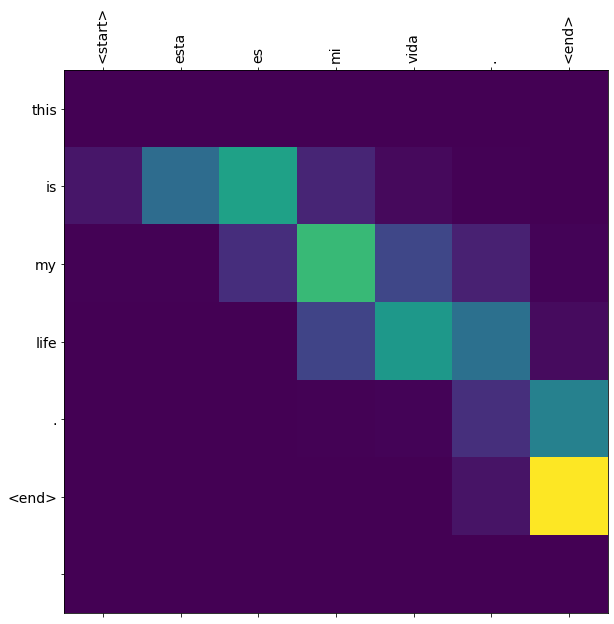

In [27]:
translate(u'esta es mi vida.')

(1, 16, 1024)
(1, 1024) (1, 1, 256)
(1, 1, 1280)
(1, 1, 1024)
output变换后
(1, 1024)
(1, 16, 1024)
(1, 1024) (1, 1, 256)
(1, 1, 1280)
(1, 1, 1024)
output变换后
(1, 1024)
(1, 16, 1024)
(1, 1024) (1, 1, 256)
(1, 1, 1280)
(1, 1, 1024)
output变换后
(1, 1024)
(1, 16, 1024)
(1, 1024) (1, 1, 256)
(1, 1, 1280)
(1, 1, 1024)
output变换后
(1, 1024)
(1, 16, 1024)
(1, 1024) (1, 1, 256)
(1, 1, 1280)
(1, 1, 1024)
output变换后
(1, 1024)
(1, 16, 1024)
(1, 1024) (1, 1, 256)
(1, 1, 1280)
(1, 1, 1024)
output变换后
(1, 1024)
(1, 16, 1024)
(1, 1024) (1, 1, 256)
(1, 1, 1280)
(1, 1, 1024)
output变换后
(1, 1024)
Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: are you still at home ? <end> 


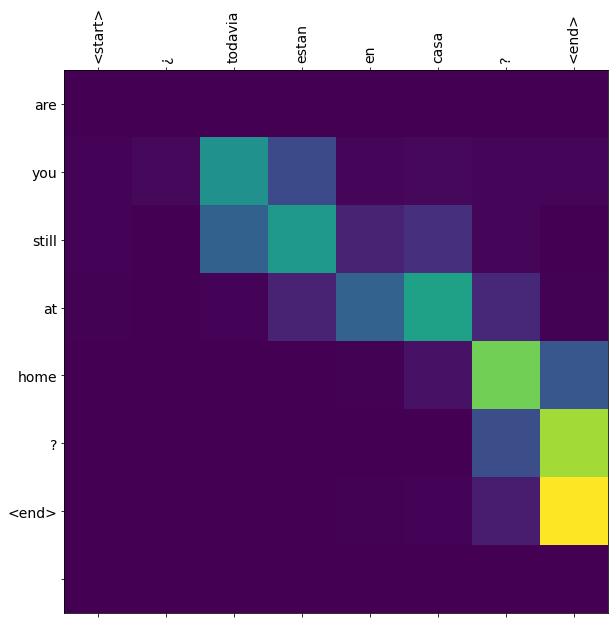

In [28]:
translate(u'¿todavia estan en casa?')

(1, 16, 1024)
(1, 1024) (1, 1, 256)
(1, 1, 1280)
(1, 1, 1024)
output变换后
(1, 1024)
(1, 16, 1024)
(1, 1024) (1, 1, 256)
(1, 1, 1280)
(1, 1, 1024)
output变换后
(1, 1024)
(1, 16, 1024)
(1, 1024) (1, 1, 256)
(1, 1, 1280)
(1, 1, 1024)
output变换后
(1, 1024)
(1, 16, 1024)
(1, 1024) (1, 1, 256)
(1, 1, 1280)
(1, 1, 1024)
output变换后
(1, 1024)
(1, 16, 1024)
(1, 1024) (1, 1, 256)
(1, 1, 1280)
(1, 1, 1024)
output变换后
(1, 1024)
(1, 16, 1024)
(1, 1024) (1, 1, 256)
(1, 1, 1280)
(1, 1, 1024)
output变换后
(1, 1024)
Input: <start> hoy es un buen dia <end>
Predicted translation: today is sunny today . <end> 


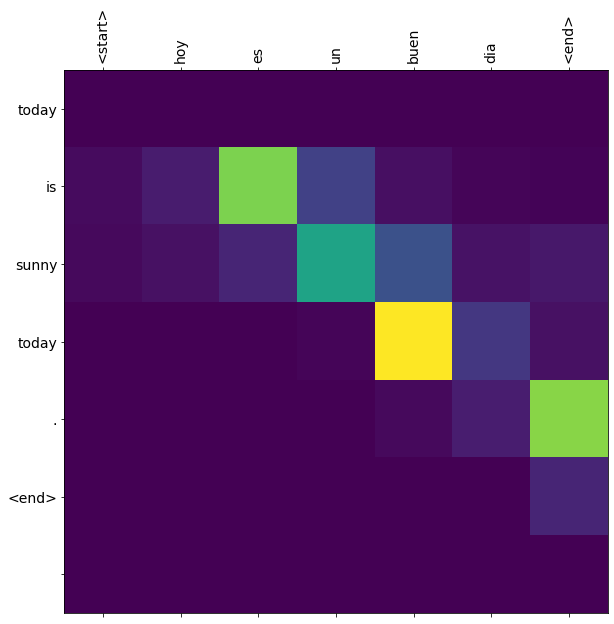

In [29]:
translate(u'Hoy es un buen día')